### Preface: this study is stage 8 in the development of a project on cryptocurrencies and step 1 in portfolio price modeling.

import required libs

In [102]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rd

import yfinance as yf
from tqdm.autonotebook import tqdm
from scipy.stats import norm

import plotly.io as pio
import plotly.graph_objects as go
from simple_colors import *

In [103]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

Upload the data <br>
The work was done with data from Dec 2014 to Feb 2023

In [104]:
interesting_tickers = ['BTC-USD'] # ['ONEQ', 'FLTB']
load = True

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='117mo', interval='1mo')['Close']
            
            # Filter rows where the day of the month is 1
            close_price_filtered = close_price[close_price.index.day == 1]
            
            close_price_dict = close_price_filtered.to_dict()
            info = get_info(ticker_obj)
            info.update(close_price_dict)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    funds_0 = pd.DataFrame(full_ticker_data)
    funds = pd.DataFrame(funds_0.iloc[:,1:].pct_change(axis='columns'))
    funds.insert(0, "shortName", funds_0.shortName)

  0%|          | 0/1 [00:00<?, ?it/s]

### Minor data preprocessing

In [105]:
BTC = funds.iloc[:, 2:-1]
interesting_tickers = ['BTC-USD']
BTC.insert(0, "shortName", interesting_tickers)
BTC.head()

,shortName,2014-11-01 00:00:00+00:00,2014-12-01 00:00:00+00:00,2015-01-01 00:00:00+00:00,2015-02-01 00:00:00+00:00,2015-03-01 00:00:00+00:00,2015-04-01 00:00:00+00:00,2015-05-01 00:00:00+00:00,2015-06-01 00:00:00+00:00,2015-07-01 00:00:00+00:00,...,2023-08-01 00:00:00+00:00,2023-09-01 00:00:00+00:00,2023-10-01 00:00:00+00:00,2023-11-01 00:00:00+00:00,2023-12-01 00:00:00+00:00,2024-01-01 00:00:00+00:00,2024-02-01 00:00:00+00:00,2024-03-01 00:00:00+00:00,2024-04-01 00:00:00+00:00,2024-05-01 00:00:00+00:00
0,BTC-USD,0.117421,-0.153034,-0.320835,0.169219,-0.039483,-0.03308,-0.025218,0.142847,0.082023,...,-0.112851,0.039969,0.285519,0.087833,0.120714,0.00751,0.437169,0.165613,-0.149954,0.113043


In [106]:
IMOEX = pd.read_excel('IMOEX.xlsx')
RGBITR = pd.read_excel('RGBITR.xlsx')

display(IMOEX.head(3))
RGBITR.head(3)

,Дата,Открытие,Закрытие,Месячная доходность
0,2014-06-01,1432.67,1476.38,0.030509
1,2014-07-01,1476.28,1379.61,-0.065482
2,2014-08-01,1378.03,1400.71,0.016458


,Дата,Открытие,Закрытие,Месячная доходность
0,2014-06-01,320.63,324.81,0.013037
1,2014-07-01,324.85,314.99,-0.030352
2,2014-08-01,314.79,313.70,-0.003463


In [107]:
funds_ = pd.DataFrame(IMOEX['Месячная доходность'].reset_index(drop=True).drop(index=[0,1,2,3,4]).astype(float))
funds_['RGBITR'] = RGBITR['Месячная доходность'].drop(index=[0,1,2,3,4]).astype(float)
funds_ = funds_.T
funds_.columns = IMOEX['Дата'][5:].values
funds_.insert(0, "shortName", ['IMOEX', 'RGBITR'])
funds_.reset_index(drop=True, inplace=True)
funds_.head()

,shortName,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,...,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00,2024-04-01 00:00:00,2024-05-01 00:00:00
0,IMOEX,0.030595,-0.088904,0.181428,0.067505,-0.075640,0.038844,-0.047563,0.027626,0.008721,...,0.046021,-0.030110,0.018869,-0.008509,-0.017986,0.036909,0.011294,0.022562,0.037734,-0.073088
1,RGBITR,-0.014356,-0.104404,0.000825,0.032974,0.054182,0.061138,0.011440,-0.004530,0.021066,...,-0.016461,-0.029582,-0.008044,0.045338,-0.002282,0.007648,-0.011606,-0.022567,-0.005716,-0.046571


In [108]:
funds_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Columns: 116 entries, shortName to 2024-05-01 00:00:00
dtypes: float64(115), object(1)
memory usage: 1.9+ KB


In [109]:
df_1 = funds_
BTC.columns = [str(i).partition(' ')[0] for i in BTC.columns]

funds_.columns = [str(i).partition(' ')[0] for i in funds_.columns]
merge_portfolio = BTC.merge(funds_, how='outer')
merge_portfolio.head()

,shortName,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,...,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01
0,BTC-USD,0.117421,-0.153034,-0.320835,0.169219,-0.039483,-0.033080,-0.025218,0.142847,0.082023,...,-0.112851,0.039969,0.285519,0.087833,0.120714,0.007510,0.437169,0.165613,-0.149954,0.113043
1,IMOEX,0.030595,-0.088904,0.181428,0.067505,-0.075640,0.038844,-0.047563,0.027626,0.008721,...,0.046021,-0.030110,0.018869,-0.008509,-0.017986,0.036909,0.011294,0.022562,0.037734,-0.073088
2,RGBITR,-0.014356,-0.104404,0.000825,0.032974,0.054182,0.061138,0.011440,-0.004530,0.021066,...,-0.016461,-0.029582,-0.008044,0.045338,-0.002282,0.007648,-0.011606,-0.022567,-0.005716,-0.046571


In [110]:
df_1.index = df_1.shortName
df_1.drop(columns='shortName', inplace = True)

merge_portfolio.index = merge_portfolio.shortName
merge_portfolio.drop(columns='shortName', inplace=True)

Corrected functions for calculating the revenue of an asset and its risk from the previous stage

In [112]:
def revenue_for_each_asset(df):
    rev_for_current_asset = 1
    list_of_rev = []
    otv_ = []
    for i in range(len(df.index)):
        
        for j in range(1,len(df.columns)):
            rev_for_current_asset *= (1 + df.iloc[i,j])
        
        list_of_rev.append(rev_for_current_asset)
        rev_for_current_asset = 1
    
    for i in range(len(list_of_rev)):
        if len(df) == 2:
            if i == 0:
                otv_.append((list_of_rev[i]**(1/df.shape[1])-1)*100*0.7)  #вес в % (70% - assets/30% - bonds)
            elif i ==1:
                otv_.append((list_of_rev[i]**(1/df.shape[1])-1)*100*0.3) 
        else:
            if i == 0:
                otv_.append((list_of_rev[i]**(1/df.shape[1])-1)*100*0.01)   #вес в % (70% - assets/30% - bonds)
            elif i ==1:
                otv_.append((list_of_rev[i]**(1/df.shape[1])-1)*100*0.69) 
            else:
                otv_.append((list_of_rev[i]**(1/df.shape[1])-1)*100*0.3)

    return sum(otv_)



def VaR(portfolio_df, weights):
    portfolio_df = portfolio_df.T
    initial_investment = 1000000
    cov_matrix = portfolio_df.cov()
    avg_rets = portfolio_df.mean()
    port_mean = np.sum(avg_rets * weights)
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    mean_investment = (1+port_mean) * initial_investment
    
    stdev_investment = initial_investment * port_stdev
    conf_level1 = 0.05
    cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
    var_1d1 = initial_investment - cutoff1

    return (max(0, var_1d1)/1000000)*100

# Recheked the results with fixed revenue function for:
- Monte Carlo simulation
- distributions for the periods
- summary table
- Markowitz method

### Monte Carlo Simulation

In [115]:
simulation_of_Carlo = pd.DataFrame(columns=['Rev_no_crypto', 'Risk_no_crypto', 'Rev_crypto', 'Risk_crypto', 'Dimension'])
length_of_df = len(merge_portfolio.columns)
for i in range(5000):
    dimension = rd.sample(range(1, length_of_df), int(np.random.randint(low=2, high=len(merge_portfolio.columns)-1, size=1)))
    rev_no_crypto = revenue_for_each_asset(df_1.iloc[:,dimension])
    Var_no_crypto = VaR(df_1.iloc[:, dimension], np.array([0.6, 0.4]))
    rev_crypto = revenue_for_each_asset(merge_portfolio.iloc[:,dimension])
    Var_crypto = VaR(merge_portfolio.iloc[:, dimension], np.array([0.05, 0.55, 0.4]))
    simulation_of_Carlo.loc[len(simulation_of_Carlo)] = [rev_no_crypto, Var_no_crypto, rev_crypto, Var_crypto, dimension]

simulation_of_Carlo

,Rev_no_crypto,Risk_no_crypto,Rev_crypto,Risk_crypto,Dimension
0,-0.193139,7.757482,-0.170673,7.321723,"[43, 67, 17, 57, 26, 59, 81, 76, 46, 99, 107, ..."
1,0.462883,6.338872,0.504480,6.003252,"[17, 84, 5, 97, 81, 38, 105, 64, 61, 107, 66, ..."
2,0.427149,7.098452,0.456287,6.708509,"[2, 79, 77, 73, 14, 22, 16, 87, 88, 3, 98, 110..."
3,0.624661,3.127721,0.767499,2.593719,"[90, 30, 58, 10, 103, 22, 112, 53, 13, 67, 92,..."
4,1.191544,5.020485,1.245402,4.375172,"[106, 13, 32, 29, 68, 80, 15, 38, 109, 36, 98,..."
...,...,...,...,...,...
4995,1.008845,4.252328,1.032215,4.214786,"[62, 14, 58, 34, 73, 112, 50, 24, 92, 49, 108,..."
4996,0.131780,7.402818,0.161190,6.841717,"[109, 78, 2, 79, 43, 8, 66, 12, 39, 110, 97, 2..."
4997,0.402298,6.658856,0.434476,6.367396,"[89, 37, 40, 59, 13, 114, 12, 101, 10, 75, 34,..."
4998,0.546293,5.993982,0.570921,5.766627,"[110, 81, 16, 2, 5, 86, 96, 93, 13, 41, 87, 11..."


In [116]:
len(simulation_of_Carlo[simulation_of_Carlo.Risk_crypto > simulation_of_Carlo.Risk_no_crypto])/len(simulation_of_Carlo) * 100

14.760000000000002

In [117]:
len(simulation_of_Carlo[simulation_of_Carlo.Rev_crypto > simulation_of_Carlo.Rev_no_crypto])/len(simulation_of_Carlo) * 100

92.84

### Thus, only 14.76% of the portfolio with cryptocurrency exceeds the risk of a portfolio without bitcoin

In [118]:
simulation_of_Carlo['Period'] = [len(i) for i in simulation_of_Carlo.Dimension]
#simulation_of_Carlo.drop(columns='Dimension', inplace=True)

name_of_period = []
for i in simulation_of_Carlo.Period:
    if i >= 72:  # more than 6 year
        name_of_period.append(2)
    elif 12<i and i<72:
        name_of_period.append(1)
    elif i<=12:
        name_of_period.append(0)

simulation_of_Carlo['name_of_period'] = name_of_period  #2-LR; 1-MiddleR; 0-SR.
#simulation_of_Carlo.drop(columns='Period', inplace=True)
simulation_of_Carlo.head()

,Rev_no_crypto,Risk_no_crypto,Rev_crypto,Risk_crypto,Dimension,Period,name_of_period
0,-0.193139,7.757482,-0.170673,7.321723,"[43, 67, 17, 57, 26, 59, 81, 76, 46, 99, 107, ...",71,1
1,0.462883,6.338872,0.504480,6.003252,"[17, 84, 5, 97, 81, 38, 105, 64, 61, 107, 66, ...",112,2
2,0.427149,7.098452,0.456287,6.708509,"[2, 79, 77, 73, 14, 22, 16, 87, 88, 3, 98, 110...",65,1
3,0.624661,3.127721,0.767499,2.593719,"[90, 30, 58, 10, 103, 22, 112, 53, 13, 67, 92,...",13,1
4,1.191544,5.020485,1.245402,4.375172,"[106, 13, 32, 29, 68, 80, 15, 38, 109, 36, 98,...",61,1


In [119]:
for index, row in simulation_of_Carlo.iterrows():
    print(row)
    break
simulation_of_Carlo['Risk crypto more'] = [1 if row['Risk_crypto'] > row['Risk_no_crypto'] else 0 
                                           for index, row in simulation_of_Carlo.iterrows()]
simulation_of_Carlo['Rev crypto more'] = [1 if row['Rev_crypto'] > row['Rev_no_crypto'] else 0 
                                           for index, row in simulation_of_Carlo.iterrows()]
simulation_of_Carlo.head()

Rev_no_crypto                                             -0.193139
Risk_no_crypto                                             7.757482
Rev_crypto                                                -0.170673
Risk_crypto                                                7.321723
Dimension         [43, 67, 17, 57, 26, 59, 81, 76, 46, 99, 107, ...
Period                                                           71
name_of_period                                                    1
Name: 0, dtype: object


,Rev_no_crypto,Risk_no_crypto,Rev_crypto,Risk_crypto,Dimension,Period,name_of_period,Risk crypto more,Rev crypto more
0,-0.193139,7.757482,-0.170673,7.321723,"[43, 67, 17, 57, 26, 59, 81, 76, 46, 99, 107, ...",71,1,0,1
1,0.462883,6.338872,0.504480,6.003252,"[17, 84, 5, 97, 81, 38, 105, 64, 61, 107, 66, ...",112,2,0,1
2,0.427149,7.098452,0.456287,6.708509,"[2, 79, 77, 73, 14, 22, 16, 87, 88, 3, 98, 110...",65,1,0,1
3,0.624661,3.127721,0.767499,2.593719,"[90, 30, 58, 10, 103, 22, 112, 53, 13, 67, 92,...",13,1,0,1
4,1.191544,5.020485,1.245402,4.375172,"[106, 13, 32, 29, 68, 80, 15, 38, 109, 36, 98,...",61,1,0,1


### Visualise the distribution of risk and return using a conventional scatter plot and a box plot

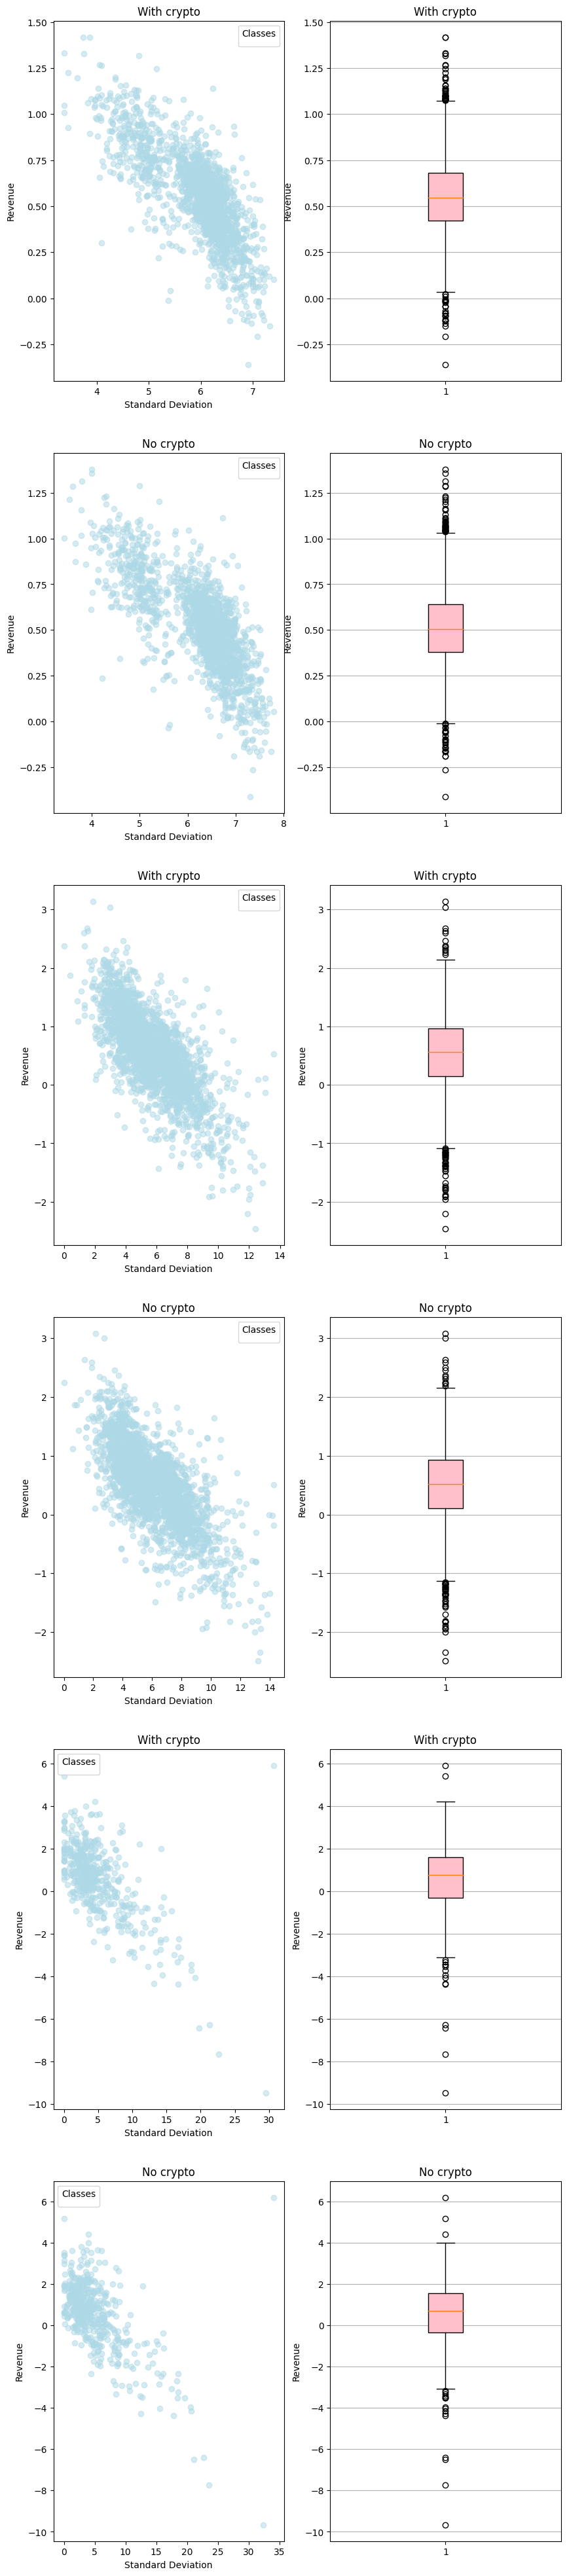

In [120]:
fig, ax = plt.subplots(6,2,figsize=(10, 50))

#LR
LR_portfolio_simulation_of_Carlo = simulation_of_Carlo[simulation_of_Carlo.name_of_period == 2]
scatter = ax[0,0].scatter(LR_portfolio_simulation_of_Carlo.Risk_crypto, LR_portfolio_simulation_of_Carlo.Rev_crypto, c='lightblue', alpha=0.5)
legend1 = ax[0,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[0,0].set_xlabel('Standard Deviation')
ax[0,0].set_ylabel('Revenue')
ax[0][0].set_title('With crypto')
ax[0][1].set_title('With crypto')
bplot1LR = ax[0,1].boxplot(LR_portfolio_simulation_of_Carlo.Rev_crypto, vert=True, patch_artist=True)
ax[0,1].set_ylabel('Revenue')
ax[0,1].yaxis.grid(True)

scatter = ax[1,0].scatter(LR_portfolio_simulation_of_Carlo.Risk_no_crypto, LR_portfolio_simulation_of_Carlo.Rev_no_crypto, c='lightblue', alpha=0.5)
legend1 = ax[1,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[1,0].set_xlabel('Standard Deviation')
ax[1,0].set_ylabel('Revenue')
bplot2LR = ax[1,1].boxplot(LR_portfolio_simulation_of_Carlo.Rev_no_crypto, vert=True, patch_artist=True)
ax[1,1].set_ylabel('Revenue')
ax[1][0].set_title('No crypto')
ax[1][1].set_title('No crypto')
ax[1,1].yaxis.grid(True)

#MR
Middle_portfolio_simulation_of_Carlo = simulation_of_Carlo[simulation_of_Carlo.name_of_period == 1]
scatter = ax[2,0].scatter(Middle_portfolio_simulation_of_Carlo.Risk_crypto, Middle_portfolio_simulation_of_Carlo.Rev_crypto, c='lightblue', alpha=0.5)
legend1 = ax[2,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[2,0].set_xlabel('Standard Deviation')
ax[2,0].set_ylabel('Revenue')
ax[2][0].set_title('With crypto')
ax[2][1].set_title('With crypto')
bplot1Md = ax[2,1].boxplot(Middle_portfolio_simulation_of_Carlo.Rev_crypto, vert=True, patch_artist=True)
ax[2,1].set_ylabel('Revenue')
ax[2,1].yaxis.grid(True)

scatter = ax[3,0].scatter(Middle_portfolio_simulation_of_Carlo.Risk_no_crypto, Middle_portfolio_simulation_of_Carlo.Rev_no_crypto, c='lightblue', alpha=0.5)
legend1 = ax[3,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[3,0].set_xlabel('Standard Deviation')
ax[3,0].set_ylabel('Revenue')
bplot2Md = ax[3,1].boxplot(Middle_portfolio_simulation_of_Carlo.Rev_no_crypto, vert=True, patch_artist=True)
ax[3,1].set_ylabel('Revenue')
ax[3][0].set_title('No crypto')
ax[3][1].set_title('No crypto')
ax[3,1].yaxis.grid(True)

#SR
SR_portfolio_simulation_of_Carlo = simulation_of_Carlo[simulation_of_Carlo.name_of_period == 0]
scatter = ax[4,0].scatter(SR_portfolio_simulation_of_Carlo.Risk_crypto, SR_portfolio_simulation_of_Carlo.Rev_crypto, c='lightblue', alpha=0.5)
legend1 = ax[4,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[4,0].set_xlabel('Standard Deviation')
ax[4,0].set_ylabel('Revenue')
ax[4][0].set_title('With crypto')
ax[4][1].set_title('With crypto')
bplot1SR = ax[4,1].boxplot(SR_portfolio_simulation_of_Carlo.Rev_crypto, vert=True, patch_artist=True)
ax[4,1].set_ylabel('Revenue')
ax[4,1].yaxis.grid(True)

scatter = ax[5,0].scatter(SR_portfolio_simulation_of_Carlo.Risk_no_crypto, SR_portfolio_simulation_of_Carlo.Rev_no_crypto, c='lightblue', alpha=0.5)
legend1 = ax[5,0].legend(*scatter.legend_elements(),
                    loc='best', title="Classes")
ax[5,0].set_xlabel('Standard Deviation')
ax[5,0].set_ylabel('Revenue')
bplot2SR = ax[5,1].boxplot(SR_portfolio_simulation_of_Carlo.Rev_no_crypto, vert=True, patch_artist=True)
ax[5,1].set_ylabel('Revenue')
ax[5][0].set_title('No crypto')
ax[5][1].set_title('No crypto')
ax[5,1].yaxis.grid(True)


colors = ['pink']
for bplot in (bplot1LR, bplot2LR, bplot1Md, bplot2Md, bplot1SR, bplot2SR):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show();

### A general graph of the relationship between revenue and risk has been prepared for all periods

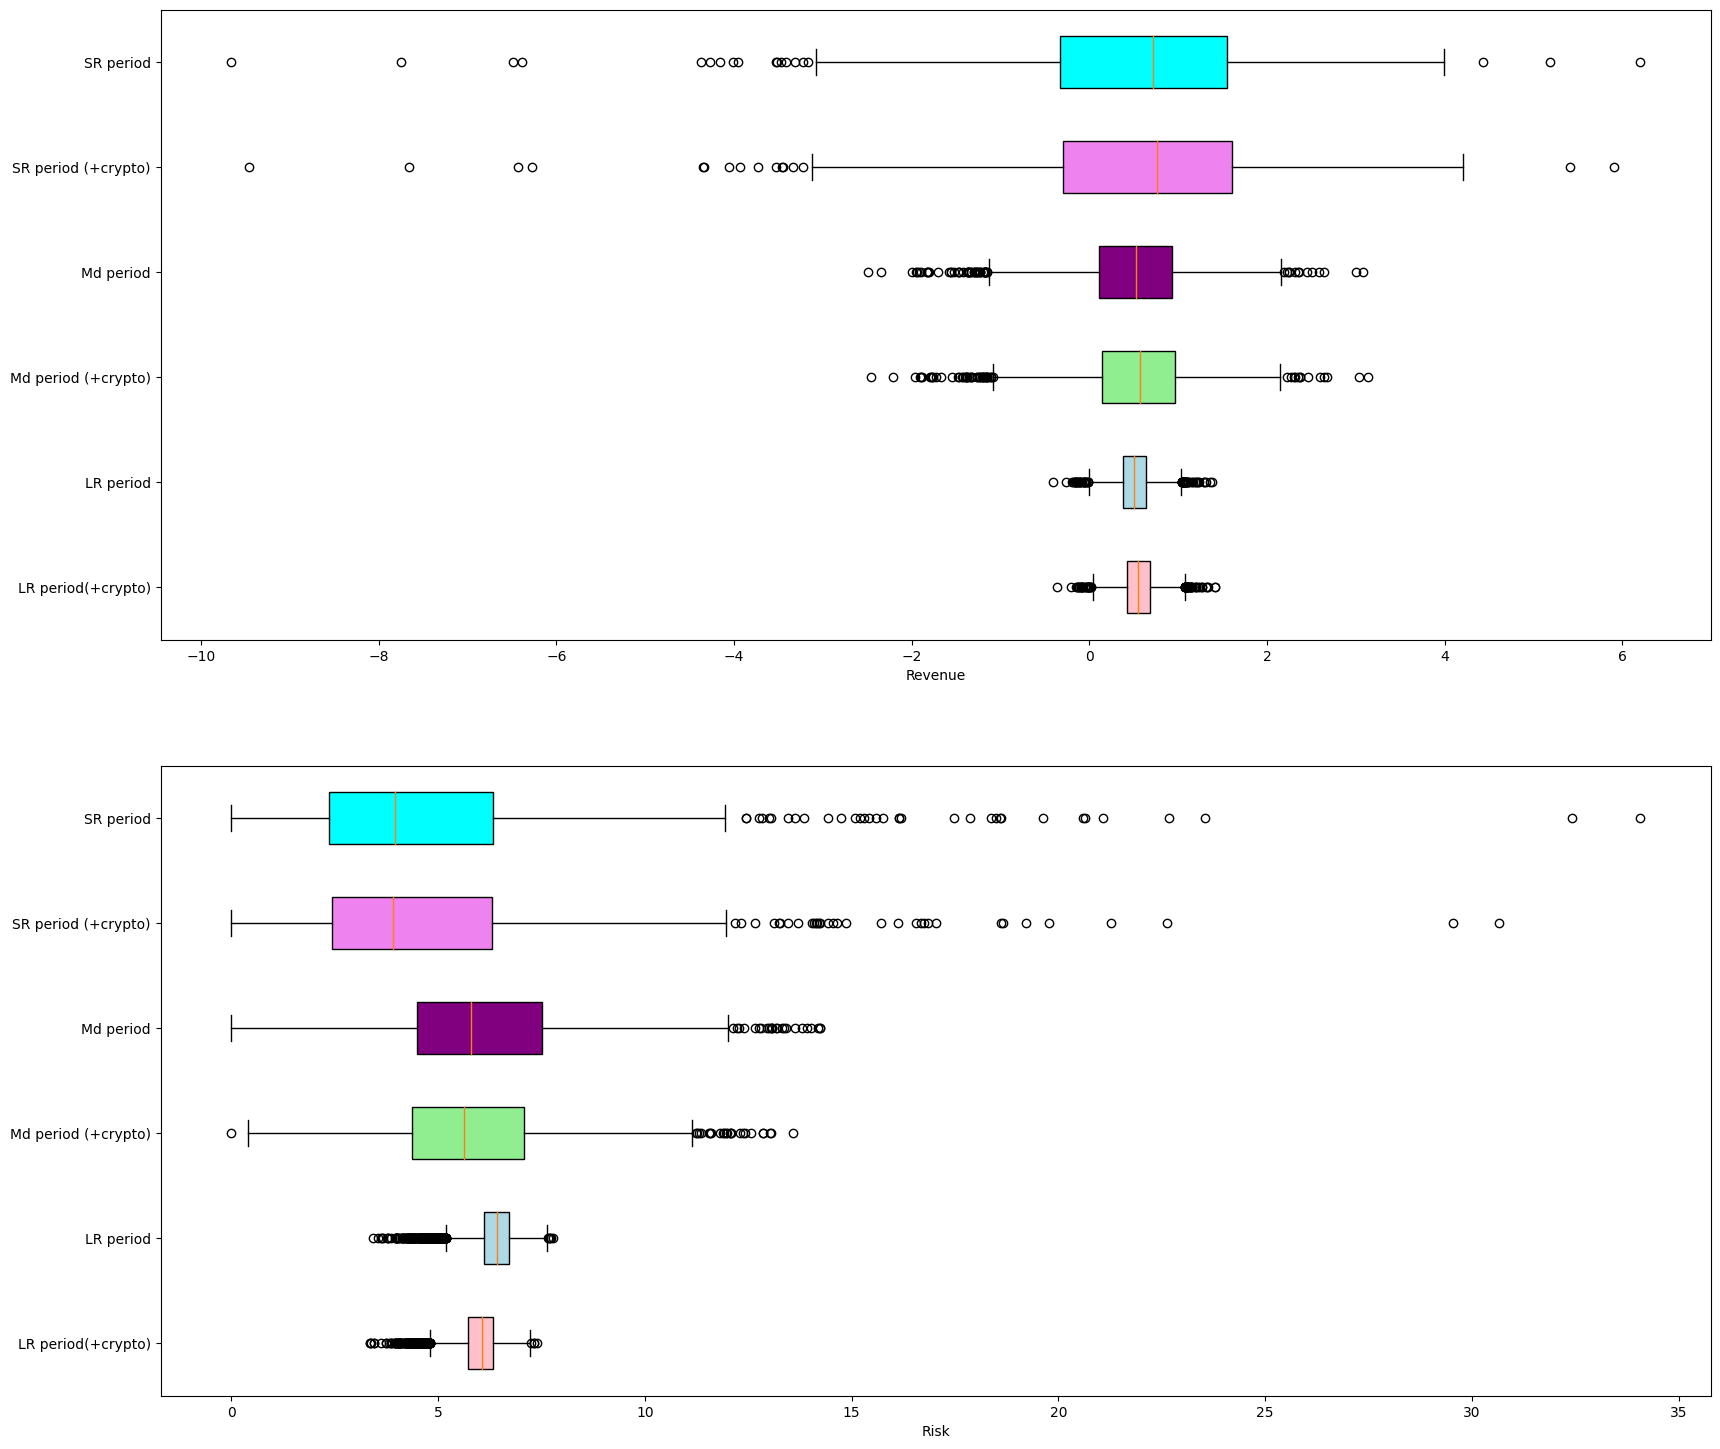

In [122]:
fig, ax = plt.subplots(2,1, figsize=(20, 18))
labels = ['LR period(+crypto)', 'LR period', 'Md period (+crypto)', 'Md period', 'SR period (+crypto)', 'SR period']


bplot_general = ax[0].boxplot([LR_portfolio_simulation_of_Carlo.Rev_crypto, LR_portfolio_simulation_of_Carlo.Rev_no_crypto,
                            Middle_portfolio_simulation_of_Carlo.Rev_crypto, Middle_portfolio_simulation_of_Carlo.Rev_no_crypto,
                            SR_portfolio_simulation_of_Carlo.Rev_crypto, SR_portfolio_simulation_of_Carlo.Rev_no_crypto], 
                           vert=False, patch_artist=True, labels=labels)

bplot_general_2 = ax[1].boxplot([LR_portfolio_simulation_of_Carlo.Risk_crypto, LR_portfolio_simulation_of_Carlo.Risk_no_crypto,
                            Middle_portfolio_simulation_of_Carlo.Risk_crypto, Middle_portfolio_simulation_of_Carlo.Risk_no_crypto,
                            SR_portfolio_simulation_of_Carlo.Risk_crypto, SR_portfolio_simulation_of_Carlo.Risk_no_crypto], 
                           vert=False, patch_artist=True, labels=labels)

ax[0].set_xlabel('Revenue')
ax[1].set_xlabel('Risk')


colors = ['pink', 'lightblue', 'lightgreen', 'purple', 'violet', 'cyan', 'yellow', 'orange']
for bplot in (bplot_general, bplot_general_2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show();

### Functions for calculating the revenue and risk of a portfolio

In [123]:
def portfolio_revenue(portfolio_df, weights):
    rev_for_current_asset = 1
    list_of_rev = []
    otv_ = []
    
    for i in range(len(portfolio_df.index)):
        
        for j in range(1,len(portfolio_df.columns)):
            rev_for_current_asset *= (1 + portfolio_df.iloc[i,j])
    
        list_of_rev.append((rev_for_current_asset**(1/portfolio_df.shape[1])-1)*100)
        rev_for_current_asset = 1

    total_rev_portfolio = np.sum(list_of_rev * weights)
    return total_rev_portfolio

def VaR(portfolio_df, weights):
    portfolio_df = portfolio_df.T
    initial_investment = 1000000
    cov_matrix = portfolio_df.cov()
    avg_rets = portfolio_df.mean()
    port_mean = np.sum(avg_rets * weights)
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    mean_investment = (1+port_mean) * initial_investment
    
    stdev_investment = initial_investment * port_stdev
    conf_level1 = 0.05
    cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
    var_1d1 = initial_investment - cutoff1

    return (var_1d1/1000000)*100

def std(portfolio_df, weights):
    risk = 0
    for i in range(len(weights)):
        risk += (weights[i]**2) * portfolio_df[portfolio_df.index == portfolio_df.index[i]].values.var()
        for j in range(i+1, len(weights)-1):
            risk += 2 * weights[i] * weights[j] * portfolio_df[portfolio_df.index == portfolio_df.index[i]].values.std()\
                                * portfolio_df[portfolio_df.index == portfolio_df.index[j]].values.std()\
                                * np.corrcoef(portfolio_df[portfolio_df.index == portfolio_df.index[i]].values, 
                                                            portfolio_df[portfolio_df.index == portfolio_df.index[j]].values)[0,1]
    return np.sqrt(risk) * 100

In [124]:
VaR(df_1, np.array([0.6, 0.4]))
VaR(merge_portfolio, np.array([1, 0, 0]))
VaR(merge_portfolio, np.array([ 0.149, -0., 0.851]))

5.345615004392818

# Create df

In [125]:
def to_DF(portfolio_with_crypto, portfolio_no_crypto):
    RISks = [3, 5, 10, 15, 20]
    opt_weights = []
    max_rev = []

    for risk in [3, 5, 10, 15, 20]:
        target_risk = risk

        #=====================================================VaR===========================================================
        # with crypto
        constraints = [
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0},
            {'type': 'ineq', 'fun': lambda weights: target_risk - VaR(portfolio_with_crypto, weights)},
            {'type': 'ineq', 'fun': lambda weights: weights-0},
            {'type': 'ineq', 'fun': lambda weights: 1 - weights}
        ]

        n_assets = len(portfolio_with_crypto.index)
        bounds = [(0, 1)] * n_assets
        initial_weights = np.ones(n_assets) / n_assets
        optimized_portfolio = minimize(lambda weights: -portfolio_revenue(portfolio_with_crypto, weights), initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
        optimal_weights = optimized_portfolio.x
        optimal_weights = np.round(optimal_weights, 3)
        optimal_return = -optimized_portfolio.fun

        opt_weights.append(optimal_weights)
        max_rev.append(optimal_return)

        # no crypto
        constraints = [
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0},  
            {'type': 'ineq', 'fun': lambda weights: target_risk - VaR(portfolio_no_crypto, weights)},
            {'type': 'ineq', 'fun': lambda weights: weights-0},  
            {'type': 'ineq', 'fun': lambda weights: 1 - weights}  
        ]

        n_assets = len(portfolio_no_crypto.index)
        bounds = [(0, 1)] * n_assets
        initial_weights = np.ones(n_assets) / n_assets
        optimized_portfolio = minimize(lambda weights: -portfolio_revenue(portfolio_no_crypto, weights), initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
        optimal_weights = optimized_portfolio.x         
        optimal_weights = np.round(optimal_weights, 3)  
        optimal_return = -optimized_portfolio.fun

        opt_weights.append(optimal_weights)
        max_rev.append(optimal_return)

        #================================================Std===========================================================
        # with crypto
        constraints = [
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0},
            {'type': 'ineq', 'fun': lambda weights: target_risk - std(portfolio_with_crypto, weights)},
            {'type': 'ineq', 'fun': lambda weights: weights-0}, 
            {'type': 'ineq', 'fun': lambda weights: 1 - weights}
        ] 
        n_assets = len(portfolio_with_crypto.index)
        bounds = [(0, 1)] * n_assets
        initial_weights = np.ones(n_assets) / n_assets
        optimized_portfolio = minimize(lambda weights: -portfolio_revenue(portfolio_with_crypto, weights), initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
        optimal_weights = optimized_portfolio.x        
        optimal_weights = np.round(optimal_weights, 3)  
        optimal_return = -optimized_portfolio.fun

        opt_weights.append(optimal_weights)
        max_rev.append(optimal_return)

        # no crypto
        constraints = [
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0},  
            {'type': 'ineq', 'fun': lambda weights: target_risk - std(portfolio_no_crypto, weights)},
            {'type': 'ineq', 'fun': lambda weights: weights-0},  
            {'type': 'ineq', 'fun': lambda weights: 1 - weights}  
        ]

        n_assets = len(portfolio_no_crypto.index)
        bounds = [(0, 1)] * n_assets
        initial_weights = np.ones(n_assets) / n_assets
        optimized_portfolio = minimize(lambda weights: -portfolio_revenue(portfolio_no_crypto, weights), initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
        optimal_weights = optimized_portfolio.x         
        optimal_weights = np.round(optimal_weights, 3)  
        optimal_return = -optimized_portfolio.fun

        opt_weights.append(optimal_weights)
        max_rev.append(optimal_return)
    
    
    
    #=============================== Making pretty final df-results ================================================
    # Create a multi-index for columns
    columns = pd.MultiIndex.from_product([RISks, ['VaR', 'std'], ['Crypto', 'No crypto']], names=['Risk', None, None])

    final_pretty_df = pd.DataFrame(index=['optimal_weights', 'optimal_revenue'], columns=columns).T

    final_pretty_df['optimal_weights'] = opt_weights
    final_pretty_df['optimal_revenue'] = max_rev
    
    
    return final_pretty_df

In [126]:
to_DF(merge_portfolio, df_1)

optimal_weights  optimal_revenue
Risk                                                      
3    VaR Crypto      [0.034, 0.015, 0.95]         0.624482
         No crypto         [0.031, 0.969]         0.483264
     std Crypto     [0.081, 0.153, 0.766]         0.823222
         No crypto         [0.427, 0.573]         0.505043
5    VaR Crypto       [0.131, 0.0, 0.869]         1.022555
         No crypto         [0.371, 0.629]         0.501943
     std Crypto      [0.205, 0.105, 0.69]         1.335518
         No crypto         [0.842, 0.158]         0.527898
10   VaR Crypto       [0.337, 0.0, 0.663]         1.872844
         No crypto             [1.0, 0.0]         0.536577
     std Crypto      [0.452, 0.008, 0.54]         2.347899
         No crypto             [1.0, 0.0]         0.536577
15   VaR Crypto       [0.515, 0.0, 0.485]         2.606506
         No crypto             [1.0, 0.0]         0.536577
     std Crypto       [0.685, 0.0, 0.315]         3.310277
         No crypto             [1.0, 0.0]         0.536577
20   VaR Crypto       [0.687, 0.0, 0.313]         3.318797
         No crypto             [1.0, 0.0]         0.536577
     std Crypto       [0.915, 0.0, 0.085]         4.259587
         No crypto             [1.0, 0.0]         0.536577

### Finding Effective Markowitz Boundaries (VaR)

In [127]:
def Making_Best_Portolio(portfolio_no_crypto, portfolio_with_crypto):
    
    fig = go.Figure()
    color = []
        
    axes_1 = []
    ayes_1 = []
    axes_2 = []
    ayes_2 = []
    AXes_scatter = []
    AYes_scatter = []
    
    # Set of varaince portfolios WITH crypro
    for x in range(0, 101):
        for y in range(0, 101):
            z = 100 - x - y 
            if 0 <= z <= 100: 
                x_normalized = x / 100.0
                y_normalized = y / 100.0 
                z_normalized = z / 100.0  
                if x_normalized + y_normalized + z_normalized == 1:
                    risk = VaR(portfolio_with_crypto, np.array([x_normalized, y_normalized, z_normalized]))
                    rev = portfolio_revenue(portfolio_with_crypto, np.array([x_normalized, y_normalized, z_normalized]))

                    AXes_scatter.append(risk)
                    AYes_scatter.append(rev)
        
    nocr_mx_risk, nocr_mx_risk_rev, nocr_mx_risk_weight, nocr_mn_risk, nocr_mn_risk_rev, nocr_mn_risk_weight = 0, 0, [], 10^5, 0, []
    # Set of varaince portfolios NO crypro
    for x in range(0, 101):
        y = 100 - x 
        if 0 <= z <= 100: 
            x_normalized = x / 100.0
            y_normalized = y / 100.0 
            if x_normalized + y_normalized == 1:
                risk = VaR(portfolio_no_crypto, np.array([x_normalized, y_normalized]))
                rev = portfolio_revenue(portfolio_no_crypto, np.array([x_normalized, y_normalized]))

                AXes_scatter.append(risk)
                AYes_scatter.append(rev)
                        
    
    fig.add_trace(go.Scatter(x=AXes_scatter, y=AYes_scatter, mode='markers', 
                             marker=dict(size=5, color=np.arange(4947), colorscale='viridis', opacity=0.5),
                             hovertemplate='<b>Risk:</b> %{x}<br><b>Revenue:</b> %{y}<extra></extra>'
                            ))
    
    # Plot efficiency board
    for risk in np.arange(1, np.max(AXes_scatter), 0.5):
        target_risk = risk
        
        constraints = [
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0},
            {'type': 'ineq', 'fun': lambda weights: target_risk - VaR(portfolio_with_crypto, weights)}, 
            {'type': 'ineq', 'fun': lambda weights: weights-0}, 
            {'type': 'ineq', 'fun': lambda weights: 1 - weights}
        ]
            
        n_assets = len(portfolio_with_crypto.index)
        bounds = [(0, 1)] * n_assets
        initial_weights = np.ones(n_assets) / n_assets
        optimized_portfolio = minimize(lambda weights: -portfolio_revenue(portfolio_with_crypto, weights), initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
        optimal_weights1 = optimized_portfolio.x        
        optimal_weights1 = np.round(optimal_weights1, 3) 
        optimal_return = portfolio_revenue(portfolio_with_crypto, optimal_weights1)
        cur_risk = VaR(portfolio_with_crypto, optimal_weights1)
        
        if risk == 7.5:
            optimal_weights_5_perc = optimal_weights1.copy()
            optimal_return_5_perc = optimal_return.copy()
            fig.add_trace(go.Scatter(x=[cur_risk], y=[optimal_return], mode='markers', 
                                     marker=dict(size=14, color='fuchsia'),
                                     name='Best portfolio at 5% risk',
                                     hovertemplate=f'<b>Risk:</b> {cur_risk}<br><b>Revenue:</b> {optimal_return}<br><b>Weights:</b> {optimal_weights1}<extra></extra>'))
        else:
            fig.add_trace(go.Scatter(x=[cur_risk], y=[optimal_return], mode='markers', 
                                     marker=dict(size=8, color='green', opacity=0.7),
                                     hovertemplate=f'<b>Risk:</b> {cur_risk}<br><b>Revenue:</b> {optimal_return}<br><b>Weights:</b> {optimal_weights1}<extra></extra>'))
        axes_1.append(cur_risk)
        ayes_1.append(optimal_return)
        
        
        constraints = [
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1.0},  
            {'type': 'ineq', 'fun': lambda weights: target_risk - VaR(portfolio_no_crypto, weights)},
            {'type': 'ineq', 'fun': lambda weights: weights-0},  
            {'type': 'ineq', 'fun': lambda weights: 1 - weights}  
        ]
            
        n_assets = len(portfolio_no_crypto.index)
        bounds = [(0, 1)] * n_assets
        initial_weights = np.ones(n_assets) / n_assets
        optimized_portfolio = minimize(lambda weights: -portfolio_revenue(portfolio_no_crypto, weights), initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
        optimal_weights = optimized_portfolio.x         
        optimal_weights = np.round(optimal_weights, 3)  
        optimal_return = portfolio_revenue(portfolio_no_crypto, optimal_weights)
        cur_risk = VaR(portfolio_no_crypto, optimal_weights)
        if optimal_return in ayes_1:
            fig.add_trace(go.Scatter(x=[cur_risk], y=[optimal_return], mode='markers', 
                                     marker=dict(size=8, color='green', opacity=0.7),
                                     hovertemplate=f'<b>Risk:</b> {cur_risk}<br><b>Revenue:</b> {optimal_return}<br><b>Weights:</b> {optimal_weights} <br><b>Weights:</b> {optimal_weights1}<extra></extra>'))
        elif risk == 7.5:
            optimal_weights_5_perc_no_crypto = optimal_weights.copy()
            optimal_return_5_perc_no_crypto = optimal_return.copy()
            fig.add_trace(go.Scatter(x=[cur_risk], y=[optimal_return], mode='markers', 
                                     marker=dict(size=14, color='fuchsia'),
                                     name='Best portfolio at 5% risk',
                                     hovertemplate=f'<b>Risk:</b> {cur_risk}<br><b>Revenue:</b> {optimal_return}<br><b>Weights:</b> {optimal_weights}<extra></extra>'))
        else:
            fig.add_trace(go.Scatter(x=[cur_risk], y=[optimal_return], mode='markers', 
                                     marker=dict(size=8, color='green', opacity=0.7),
                                     hovertemplate=f'<b>Risk:</b> {cur_risk}<br><b>Revenue:</b> {optimal_return}<br><b>Weights:</b> {optimal_weights} <extra></extra>'))

        axes_2.append(cur_risk)
        ayes_2.append(optimal_return)
    
    # Compute effective portfolios in 1 border
    fig.add_trace(go.Scatter(x=axes_1, y=ayes_1, mode='lines', 
                             line=dict(color='red', width=2),
                             showlegend=False
                            ))
    fig.add_trace(go.Scatter(x=axes_2, y=ayes_2, mode='lines', 
                             line=dict(color='red', width=2),
                             showlegend=False
                            ))
    
    # Configuration to hide the trace selection panel if config=False
    config = False
    if not config:
        fig.update_layout(showlegend=False)
    
    fig.update_layout(title='# Portfolio with crypto VS Portfolio without crypto', 
                      xaxis=dict(title='Risk (%)'),
                      yaxis=dict(title='Revenue (%)'),
                      hovermode='closest')
    
    
    return optimal_weights_5_perc, optimal_return_5_perc, VaR(portfolio_with_crypto, optimal_weights_5_perc),\
            optimal_weights_5_perc_no_crypto, optimal_return_5_perc_no_crypto,\
            VaR(portfolio_no_crypto, optimal_weights_5_perc_no_crypto), fig

In [128]:
result = Making_Best_Portolio(df_1, merge_portfolio)
display(result[-1])

print(f'Non-crypto portfolio base weights: {result[3]}')
print(f'Portfolio returns with selected weights: {round(result[4],2)}%')
print(f'Risk (VaR) of this portfolio: {round(result[5],1)}%')
print(f'------------------------------------------------------------------')
print(f'The best weights for a portfolio with crypto: {result[0]}')
print(f'Portfolio returns with selected weights: {round(result[1],2)}%')
print(f'Risk (VaR) of this portfolio: {round(result[2],1)}%')

Наилучшие веса для портфеля без криптовалюты: [0.789 0.211]
Выручка портфеля с выбранными весами: 0.52%
Риск (VaR) данного портфеля: 7.5%
------------------------------------------------------------------
Наилучшие веса для портфеля с криптовалютой: [0.242 0.    0.758]
Выручка портфеля с выбранными весами: 1.48%
Риск (VaR) данного портфеля: 7.5%


# Exponentially weighted moving average (EWMA) modeling

### Minor data preprocessing

In [148]:
BTC = pd.read_excel('BTC-USD (Last data - May 2024).xlsx')
BTC.head()

,Дата,Открытие,Закрытие,Месячная доходность
0,2014-10-01,387.427002,338.321014,-0.126749
1,2014-11-01,338.649994,378.046997,0.116335
2,2014-12-01,378.248993,320.192993,-0.153486
3,2015-01-01,320.434998,217.464005,-0.321348
4,2015-02-01,216.867004,254.263000,0.172437


In [149]:
BTC.tail()

,Дата,Открытие,Закрытие,Месячная доходность
112,2024-02-01,42569.761719,61198.382813,0.437602
113,2024-03-01,61168.062500,71333.648438,0.166191
114,2024-04-01,71333.484375,60636.855469,-0.149952
115,2024-05-01,60609.496094,67491.414063,0.113545
116,2024-06-01,67489.609375,66639.046875,-0.012603


In [130]:
IMOEX

,Дата,Открытие,Закрытие,Месячная доходность
0,2014-06-01,1432.67,1476.38,0.030509
1,2014-07-01,1476.28,1379.61,-0.065482
2,2014-08-01,1378.03,1400.71,0.016458
3,2014-09-01,1401.34,1411.07,0.006943
4,2014-10-01,1410.33,1488.47,0.055405
...,...,...,...,...
115,2024-01-01,3099.78,3214.19,0.036909
116,2024-02-01,3220.43,3256.80,0.011294
117,2024-03-01,3259.00,3332.53,0.022562
118,2024-04-01,3343.66,3469.83,0.037734


In [150]:
RGBITR = RGBITR.drop(index=[0,1,2,3,4, 120]).reset_index(drop=True)
IMOEX = IMOEX.drop(index=[0,1,2,3,4]).reset_index(drop=True)
BTC = BTC.drop(index=[0, 116]).reset_index(drop=True)

In [151]:
IMOEX_EWMA = IMOEX[['Дата', 'Закрытие', 'Месячная доходность']].copy()
RGBITR_EWMA = RGBITR[['Дата', 'Закрытие', 'Месячная доходность']].copy()
BTC_EWMA = BTC[['Дата', 'Закрытие', 'Месячная доходность']].copy()
BTC_EWMA.head()

,Дата,Закрытие,Месячная доходность
0,2014-11-01,378.046997,0.116335
1,2014-12-01,320.192993,-0.153486
2,2015-01-01,217.464005,-0.321348
3,2015-02-01,254.263000,0.172437
4,2015-03-01,244.223999,-0.039558


# EWMA_Results

In [320]:
def EWMA(ewma_df, num_of_scenario=0):
    
    sigma_on_i_scenario = []
    alpha = 0.94
    ewma_df_train = ewma_df.loc[num_of_scenario:int(ewma_df.shape[0]/2)-1 + num_of_scenario].reset_index(drop=True).copy()
    for index, row in ewma_df_train.iterrows():
        if index == 0:
            sigma_on_i_scenario.append(np.NaN)
        elif index == 1:
            sigma_on_i_scenario.append(ewma_df_train['Месячная доходность'].std())
        else:
            sigma_on_i_scenario.append(np.sqrt(alpha*sigma_on_i_scenario[index-1]**2 + (1 - alpha)*ewma_df_train.loc[index-1, 'Месячная доходность']**2)) #'-1' - because (i-1)

    ewma_df_train['Волатильность'] = sigma_on_i_scenario

    new_price = []
    for index, row in ewma_df_train.iterrows():
        if index != 0 and index != len(ewma_df_train) - 1:
            new_price.append(ewma_df_train.loc[len(ewma_df_train)-2, 'Закрытие']*(ewma_df_train.loc[index-1, 'Закрытие'] + \
                                                                        (row['Закрытие'] - ewma_df_train.loc[index-1, 'Закрытие']) *\
                                                                       sigma_on_i_scenario[-1]/row['Волатильность']) / ewma_df_train.loc[index-1, 'Закрытие'])
        else:
            new_price.append(np.NaN)

    ewma_df_train['Стоимость_актива_завтра_по_i_сценарию'] = new_price
    # Calculate lower and upper bounds for outlier detection
    Q1 = ewma_df_train['Стоимость_актива_завтра_по_i_сценарию'].quantile(0.25)
    Q3 = ewma_df_train['Стоимость_актива_завтра_по_i_сценарию'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Data filtering to eliminate outliers
    filtered_data = ewma_df_train[(ewma_df_train['Стоимость_актива_завтра_по_i_сценарию'] >= lower_bound) &
                                  (ewma_df_train['Стоимость_актива_завтра_по_i_сценарию'] <= upper_bound)]

    return {ewma_df.loc[int(ewma_df.shape[0]/2) + num_of_scenario]['Дата']:
                         [lower_bound, upper_bound]}

In [298]:
cnt_bad_prediction_RGBITR = 0
for i in range(int(RGBITR_EWMA.shape[0]/2)+1):
    cnt_bad_prediction_RGBITR += EWMA(RGBITR_EWMA, num_of_scenario=i)
cnt_bad_prediction_RGBITR

2019-10-01 00:00:00
2019-11-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-10-01 00:00:00
2021-11-01 00:00:00
2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2023-09-01 00:00:00
2024-05-01 00:00:00


16

In [258]:
# result_RGBITR_EWMA_for_final_visual = ''
# for i in range(int(RGBITR_EWMA.shape[0]/2)+1):
#     if i == 0:
#         result_RGBITR_EWMA_for_final_visual = pd.DataFrame(EWMA(RGBITR_EWMA, num_of_scenario=i), index=['Low_ci', 'Up_ci']).T
#     else:
#         result_RGBITR_EWMA_for_final_visual.loc[list(EWMA(RGBITR_EWMA, num_of_scenario=i).keys())[0]] = list(EWMA(RGBITR_EWMA, num_of_scenario=i).values())[0]

# print(f'How many percent of the modeled intervals did not cover the actual value in the RGBITR simulation: {cnt_bad_prediction_RGBITR}')

# cnt_bad_prediction_IMOEX = 0
# for i in range(int(IMOEX_EWMA.shape[0]/2)):
#     cnt_bad_prediction_IMOEX += EWMA(IMOEX_EWMA, num_of_scenario=i)

# print(f'How many percent of the modeled intervals did not cover the actual value in the IMOEX simulation?: {cnt_bad_prediction_IMOEX}')

# cnt_bad_prediction_BTC = 0
# for i in range(int(BTC_EWMA.shape[0]/2)):
#     cnt_bad_prediction_BTC += EWMA(BTC_EWMA, num_of_scenario=i)

# print(f'How many percent of the modeled intervals did not cover the actual value in the Bitcoin simulation?: {cnt_bad_prediction_BTC}')

2019-10-01 00:00:00
2019-11-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-10-01 00:00:00
2021-11-01 00:00:00
2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2023-09-01 00:00:00
2024-05-01 00:00:00


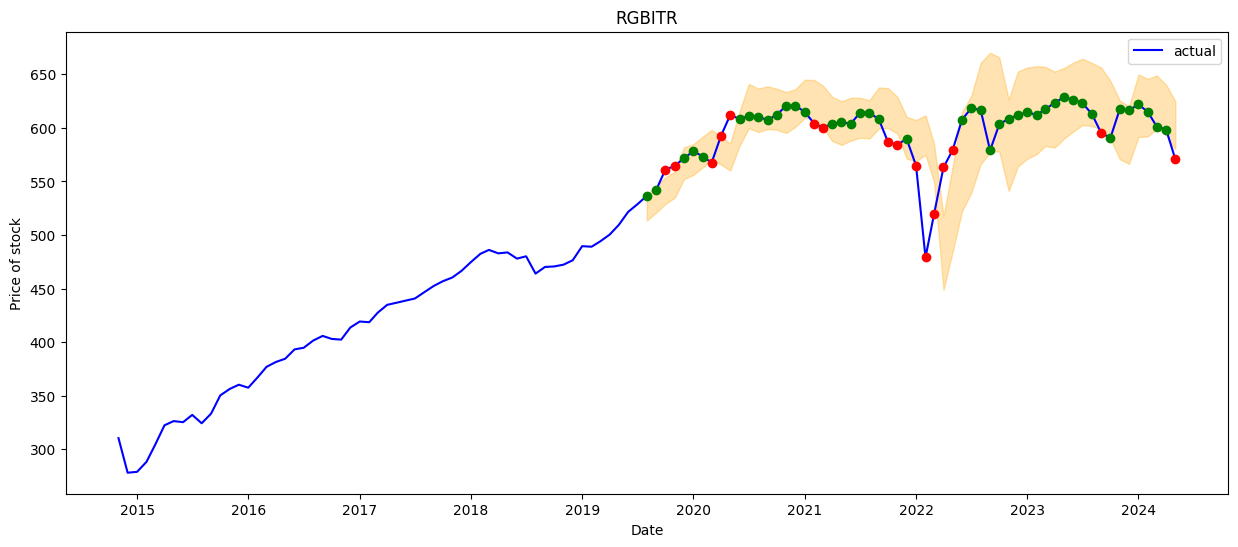

In [323]:
result_RGBITR_EWMA_for_final_visual = ''
for i in range(int(RGBITR_EWMA.shape[0]/2)+1):
    if i == 0:
        result_RGBITR_EWMA_for_final_visual = pd.DataFrame(EWMA(RGBITR_EWMA, num_of_scenario=i), index=['Low_ci', 'Up_ci']).T
    else:
        result_RGBITR_EWMA_for_final_visual.loc[list(EWMA(RGBITR_EWMA, num_of_scenario=i).keys())[0]] = list(EWMA(RGBITR_EWMA, num_of_scenario=i).values())[0]


frtr_for_visual_try_1 = RGBITR_EWMA[['Дата', 'Закрытие']].copy()
frtr_for_visual_try_1.index = RGBITR_EWMA['Дата']
frtr_for_visual_try_1.drop(columns='Дата', inplace=True)
frtr_for_visual_try_1.rename_axis(None, inplace=True)

def plot_forecast(actual, forecast_mean, forecast_ci, title):
    plt.figure(figsize=(15, 6))

    # Plot data before forecast start index
    start_index = forecast_mean.index[0]
    actual_before_forecast = actual[:start_index]
    plt.plot(actual_before_forecast, label='actual', color='blue')
    plt.plot(actual[forecast_mean.index[1]:], color='blue')
    # Plot data from forecast start index with color coding
    actual_from_forecast = actual[start_index:]
    
    for i in range(len(actual_from_forecast)):
        date = actual_from_forecast.index[i]
        value = actual_from_forecast.loc[date]['Закрытие']
        lower_bound = forecast_ci.loc[date, forecast_ci.columns[0]]
        upper_bound = forecast_ci.loc[date, forecast_ci.columns[1]]

        if lower_bound <= value <= upper_bound:
            color = 'green'
        else:
            print(date)
            color = 'red'

        plt.plot(date, value, 'o', color=color)

    plt.fill_between(forecast_mean.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='orange', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price of stock')
    plt.show()


# Plot the results
plot_forecast(frtr_for_visual_try_1, result_RGBITR_EWMA_for_final_visual, result_RGBITR_EWMA_for_final_visual, 'RGBITR')

2020-02-01 00:00:00
2020-03-01 00:00:00
2020-10-01 00:00:00
2020-12-01 00:00:00
2021-12-01 00:00:00
2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00


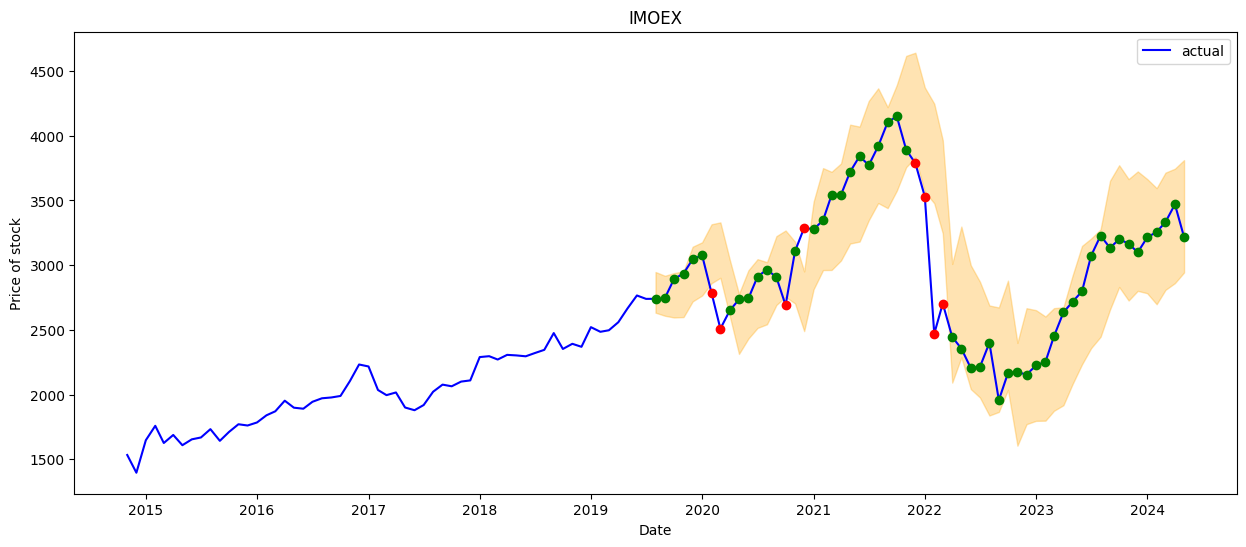

In [324]:
result_IMOEX_EWMA_for_final_visual = ''
for i in range(int(IMOEX_EWMA.shape[0]/2)+1):
    if i == 0:
        result_IMOEX_EWMA_for_final_visual = pd.DataFrame(EWMA(IMOEX_EWMA, num_of_scenario=i), index=['Low_ci', 'Up_ci']).T
    else:
        result_IMOEX_EWMA_for_final_visual.loc[list(EWMA(IMOEX_EWMA, num_of_scenario=i).keys())[0]] = list(EWMA(IMOEX_EWMA, num_of_scenario=i).values())[0]


frtr_for_visual_try_1_IMOEX = IMOEX_EWMA[['Дата', 'Закрытие']].copy()
frtr_for_visual_try_1_IMOEX.index = IMOEX_EWMA['Дата']
frtr_for_visual_try_1_IMOEX.drop(columns='Дата', inplace=True)
frtr_for_visual_try_1_IMOEX.rename_axis(None, inplace=True)

def plot_forecast(actual, forecast_mean, forecast_ci, title):
    plt.figure(figsize=(15, 6))

    start_index = forecast_mean.index[0]
    actual_before_forecast = actual[:start_index]
    plt.plot(actual_before_forecast, label='actual', color='blue')
    plt.plot(actual[forecast_mean.index[1]:], color='blue')
    actual_from_forecast = actual[start_index:]
    
    for i in range(len(actual_from_forecast)):
        date = actual_from_forecast.index[i]
        value = actual_from_forecast.loc[date]['Закрытие']
        lower_bound = forecast_ci.loc[date, forecast_ci.columns[0]]
        upper_bound = forecast_ci.loc[date, forecast_ci.columns[1]]

        if lower_bound <= value <= upper_bound:
            color = 'green'
        else:
            print(date)
            color = 'red'

        plt.plot(date, value, 'o', color=color)

    plt.fill_between(forecast_mean.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='orange', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price of stock')
    plt.show()

plot_forecast(frtr_for_visual_try_1_IMOEX, result_IMOEX_EWMA_for_final_visual, result_IMOEX_EWMA_for_final_visual, 'IMOEX')

2020-11-01 00:00:00
2020-12-01 00:00:00
2024-03-01 00:00:00


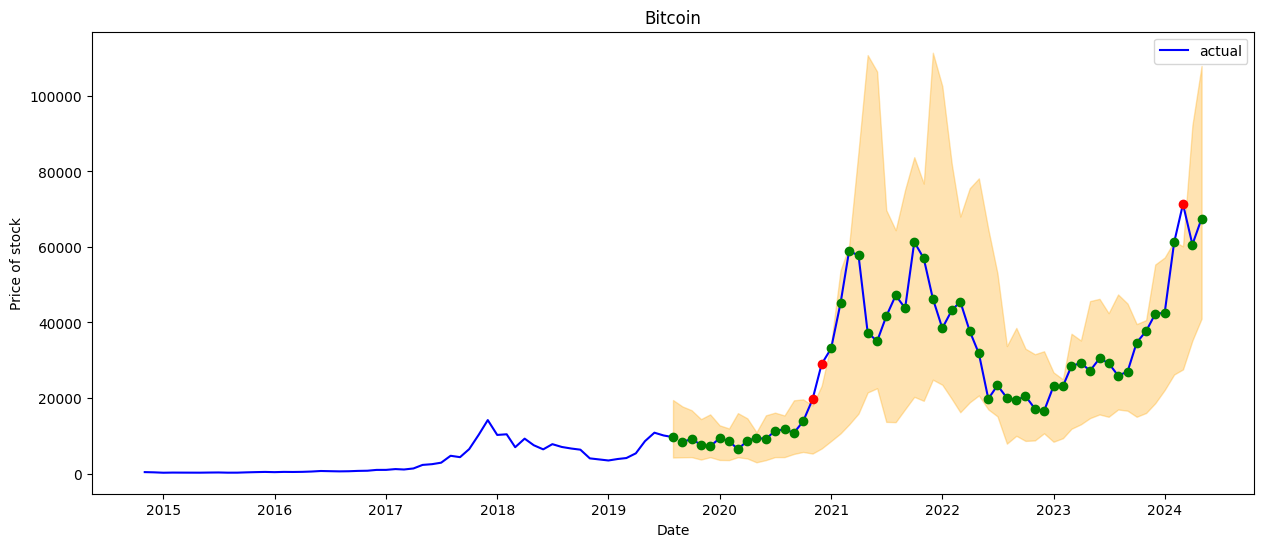

In [325]:
result_BTC_EWMA_for_final_visual = ''
for i in range(int(BTC_EWMA.shape[0]/2)+1):
    if i == 0:
        result_BTC_EWMA_for_final_visual = pd.DataFrame(EWMA(BTC_EWMA, num_of_scenario=i), index=['Low_ci', 'Up_ci']).T
    else:
        result_BTC_EWMA_for_final_visual.loc[list(EWMA(BTC_EWMA, num_of_scenario=i).keys())[0]] = list(EWMA(BTC_EWMA, num_of_scenario=i).values())[0]


frtr_for_visual_try_1_BTC = BTC_EWMA[['Дата', 'Закрытие']].copy()
frtr_for_visual_try_1_BTC.index = BTC_EWMA['Дата']
frtr_for_visual_try_1_BTC.drop(columns='Дата', inplace=True)
frtr_for_visual_try_1_BTC.rename_axis(None, inplace=True)

def plot_forecast(actual, forecast_mean, forecast_ci, title):
    plt.figure(figsize=(15, 6))

    start_index = forecast_mean.index[0]
    actual_before_forecast = actual[:start_index]
    plt.plot(actual_before_forecast, label='actual', color='blue')
    plt.plot(actual[forecast_mean.index[1]:], color='blue')
    actual_from_forecast = actual[start_index:]
    
    for i in range(len(actual_from_forecast)):
        date = actual_from_forecast.index[i]
        value = actual_from_forecast.loc[date]['Закрытие']
        lower_bound = forecast_ci.loc[date, forecast_ci.columns[0]]
        upper_bound = forecast_ci.loc[date, forecast_ci.columns[1]]

        if lower_bound <= value <= upper_bound:
            color = 'green'
        else:
            print(date)
            color = 'red'

        plt.plot(date, value, 'o', color=color)

    plt.fill_between(forecast_mean.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='orange', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price of stock')
    plt.show()


plot_forecast(frtr_for_visual_try_1_BTC, result_BTC_EWMA_for_final_visual, result_BTC_EWMA_for_final_visual, 'Bitcoin')

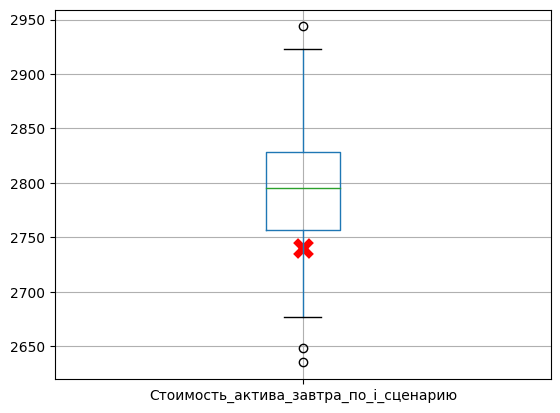

In [315]:
for i in range(int(IMOEX_EWMA.shape[0]/2)):
    EWMA(IMOEX_EWMA, num_of_scenario=i)
    break

# Conclusion:
1. Work with the data of the Russian market.
2. Re-checked the results for the main stages (interesting fact that more than in 85% of the total portfolios simulations the risk for portfolio with bitcoin lower (or equal) with the portfolio without it. Moreover, in 92%+ of the cases the return of the portfolio with 1% bitcoin increased the return of the portfolio without it.
3. The optimal weight of bitcoin in Russian portfolio for financial assets Bitcoin, IMOEX and RGBITR is 24.2% and the return of this portfolio is precisely three times higher than in the best portfolio without it.
4. EWMA modeling has shown that in more than 90% of all simulations of the future the obtained results are also credible!
5. Thus, bitcoin as a leader in crypto markets can be a diversifying instrument for investors even at the low risk percentage (between 3 and 8)!